In [5]:
# Core libraries
import pandas as pd
import numpy as np
import sqlite3
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (we’ll use later)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Change to project root (adjust as needed)
os.chdir("C:/Projects/Emissions_Analysis_Capstone")

In [6]:
# File paths
livestock_path = "raw_data/GLEAM_LivestockEmissions.csv"

# Load CSVs
livestock_df = pd.read_csv(livestock_path)

# Preview data
print("Livestock dataset shape:", livestock_df.shape)
display(livestock_df.head())

Livestock dataset shape: (583, 22)


,Region,Animal species,Production system,Commodity,Emission Intensity (kg CO2e per kg protein),Production (kg protein),Total GHG emissions (kg CO2e),Total CO2 emissions (kg CO2e),Total CH4 emissions (kg CO2e),Total N2O emissions (kg CO2e),...,"Feed: fertilizer & crop residues, N2O (kg CO2e)","Feed: applied & deposited manure, N2O (kg CO2e)","LUC: soy & palm, CO2 (kg CO2e)","LUC: pasture expansion, CO2 (kg CO2e)","Enteric fermentation, CH4 (kg CO2e)","Manure management, CH4 (kg CO2e)","Manure management, N2O (kg CO2e)","Direct energy, CO2 (kg CO2e)","Indirect energy, CO2 (kg CO2e)","Postfarm, CO2 (kg CO2e)"
0,Global,Cattle,Aggregated,Aggregated,160.3,2.916310e+10,4.674630e+12,9.449299e+11,2.648727e+12,1.080973e+12,...,1.740732e+11,7.419864e+11,4.687954e+10,3.870062e+11,2.509275e+12,1.394522e+11,1.649130e+11,4.215542e+10,1.585653e+10,9.955932e+10
1,Global,Cattle,Aggregated,Milk,86.7,1.888089e+10,1.637519e+12,2.756914e+11,9.676442e+11,3.941834e+11,...,7.166208e+10,2.543885e+11,1.497421e+10,NaN,8.856352e+11,8.200906e+10,6.813278e+10,2.993485e+10,3.252889e+09,8.929544e+10
2,Global,Cattle,Aggregated,Meat,295.4,1.028222e+10,3.037111e+12,6.692385e+11,1.681083e+12,6.867892e+11,...,1.024111e+11,4.875979e+11,3.190534e+10,3.870062e+11,1.623640e+12,5.744310e+10,9.678019e+10,1.222057e+10,1.260364e+10,1.026388e+10
3,Global,Cattle,Grassland systems,Aggregated,206.3,1.033817e+10,2.133054e+12,5.628062e+11,1.052965e+12,5.172829e+11,...,5.253660e+10,4.267612e+11,8.194330e+09,3.870062e+11,9.969096e+11,5.605552e+10,3.798508e+10,1.417326e+10,4.303272e+09,3.773092e+10
4,Global,Cattle,Grassland systems,Milk,95.0,6.940654e+09,6.592844e+11,9.286140e+10,3.713461e+11,1.950770e+11,...,2.156126e+10,1.587838e+11,2.412100e+09,NaN,3.369018e+11,3.444428e+10,1.473188e+10,1.078605e+10,9.998435e+08,3.462338e+10


In [7]:
# Drop duplicate rows
livestock_df.drop_duplicates(inplace=True)

# Handle missing values (basic strategy — we’ll refine later)
livestock_df.fillna(0, inplace=True)

# Optionally rename columns for clarity
livestock_df.rename(columns=lambda x: x.strip().lower().replace(' ', '_'), inplace=True)

In [8]:
# Define database path
db_path = os.path.join('emissions_data', 'emissionsdata.sqlite')

# Ensure the database folder exists
os.makedirs(os.path.dirname(db_path), exist_ok=True)

# Connect to SQLite
conn = sqlite3.connect(db_path)


# --- Clean column names for both CSVs ---
# Standardize: lowercase, underscores, remove special characters
def clean_columns(df):
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('[^a-z0-9_]', '', regex=True)
    )
    return df


livestock_df = clean_columns(livestock_df)
#vehicle_df = clean_columns(vehicle_df)

# --- Select only desired columns ---
livestock_subset = livestock_df[
    [
        'region',
        'animal_species',
        'production_system',
        'commodity',
        'total_co2_emissions_kg_co2e',
        'total_n2o_emissions_kg_co2e',
    ]
].copy()

# Optional: rename for consistent database naming
livestock_subset.rename(
    columns={
        'animal_species': 'animal_type',
        'production_system': 'production_system',
        'commodity': 'commodity',
        'total_co2_emissions_kg_co2e': 'co2_emissions_kg',
        'total_n2o_emissions_kg_co2e': 'n2o_emissions_kg',
    },
    inplace=True,
)

# --- Write to SQLite ---
livestock_subset.to_sql('livestock_emissions', conn, if_exists='replace', index=False)
#
# --- Verify tables ---
print(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn))

# Preview first few rows
print("\nLivestock sample:")
print(pd.read_sql("SELECT * FROM livestock_emissions LIMIT 5;", conn))

print("\nVehicle sample:")
print(pd.read_sql("SELECT * FROM vehicle_emissions LIMIT 5;", conn))

#conn.close()

                  name
0    vehicle_emissions
1  livestock_emissions

Livestock sample:
   region animal_type  production_system   commodity  co2_emissions_kg  \
0  Global      Cattle         Aggregated  Aggregated      9.449299e+11   
1  Global      Cattle         Aggregated        Milk      2.756914e+11   
2  Global      Cattle         Aggregated        Meat      6.692385e+11   
3  Global      Cattle  Grassland systems  Aggregated      5.628062e+11   
4  Global      Cattle  Grassland systems        Milk      9.286140e+10   

   n2o_emissions_kg  
0      1.080973e+12  
1      3.941834e+11  
2      6.867892e+11  
3      5.172829e+11  
4      1.950770e+11  

Vehicle sample:
    make       model  cylinders fuel_type  fuel_consumption_mpg  \
0  ACURA         ILX          4         Z                    33   
1  ACURA         ILX          4         Z                    29   
2  ACURA  ILX HYBRID          4         Z                    48   
3  ACURA     MDX 4WD          6         Z         

In [9]:
print("Livestock columns:", livestock_df.columns.tolist())

Livestock columns: ['region', 'animal_species', 'production_system', 'commodity', 'emission_intensity_kg_co2e_per_kg_protein', 'production_kg_protein', 'total_ghg_emissions_kg_co2e', 'total_co2_emissions_kg_co2e', 'total_ch4_emissions_kg_co2e', 'total_n2o_emissions_kg_co2e', 'feed_co2_kg_co2e', 'feed_ch4_kg_co2e', 'feed_fertilizer__crop_residues_n2o_kg_co2e', 'feed_applied__deposited_manure_n2o_kg_co2e', 'luc_soy__palm_co2_kg_co2e', 'luc_pasture_expansion_co2_kg_co2e', 'enteric_fermentation_ch4_kg_co2e', 'manure_management_ch4_kg_co2e', 'manure_management_n2o_kg_co2e', 'direct_energy_co2_kg_co2e', 'indirect_energy_co2_kg_co2e', 'postfarm_co2_kg_co2e']


In [10]:
livestock_data = pd.read_sql("SELECT * FROM livestock_emissions", conn)

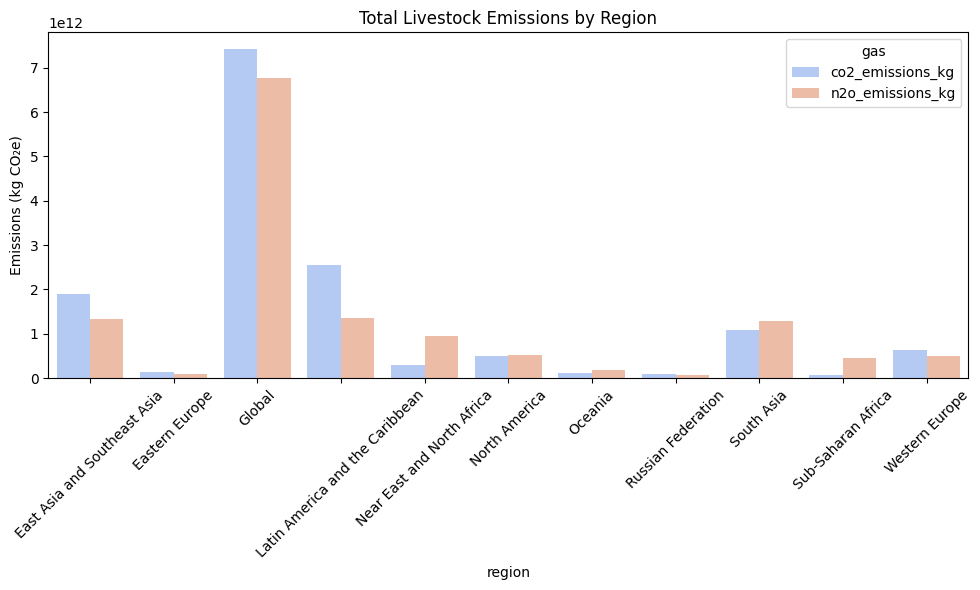

In [11]:
plt.figure(figsize=(10, 6))
region_emissions = livestock_subset.groupby('region')[
    ['co2_emissions_kg', 'n2o_emissions_kg']
].sum().reset_index().melt(id_vars='region', var_name='gas', value_name='emissions')

sns.barplot(
    data=region_emissions,
    x='region', y='emissions', hue='gas', palette='coolwarm'
)
plt.title('Total Livestock Emissions by Region')
plt.xticks(rotation=45)
plt.ylabel('Emissions (kg CO₂e)')
plt.tight_layout()
plt.show()

C:\Users\derek\AppData\Local\Temp\ipykernel_21700\2243856550.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


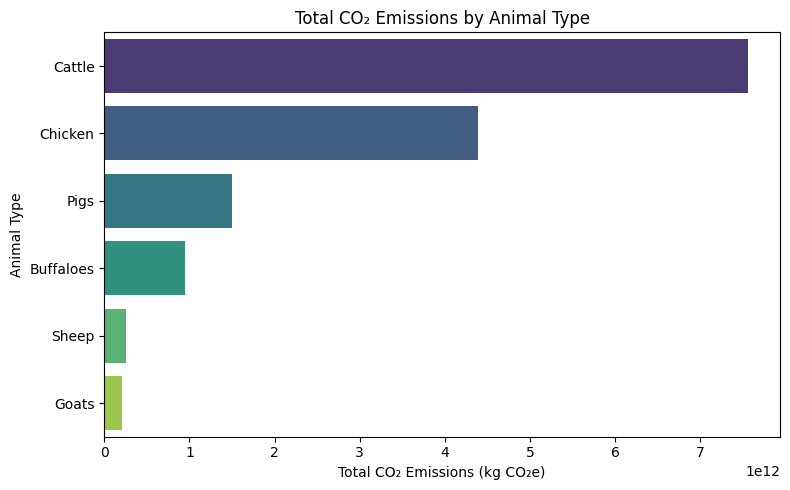

In [12]:
plt.figure(figsize=(8, 5))
species_emissions = livestock_subset.groupby('animal_type')[
    'co2_emissions_kg'
].sum().sort_values(ascending=False).reset_index()

sns.barplot(
    data=species_emissions,
    y='animal_type', x='co2_emissions_kg', palette='viridis'
)
plt.title('Total CO₂ Emissions by Animal Type')
plt.xlabel('Total CO₂ Emissions (kg CO₂e)')
plt.ylabel('Animal Type')
plt.tight_layout()
plt.show()

C:\Users\derek\AppData\Local\Temp\ipykernel_21700\2778958840.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


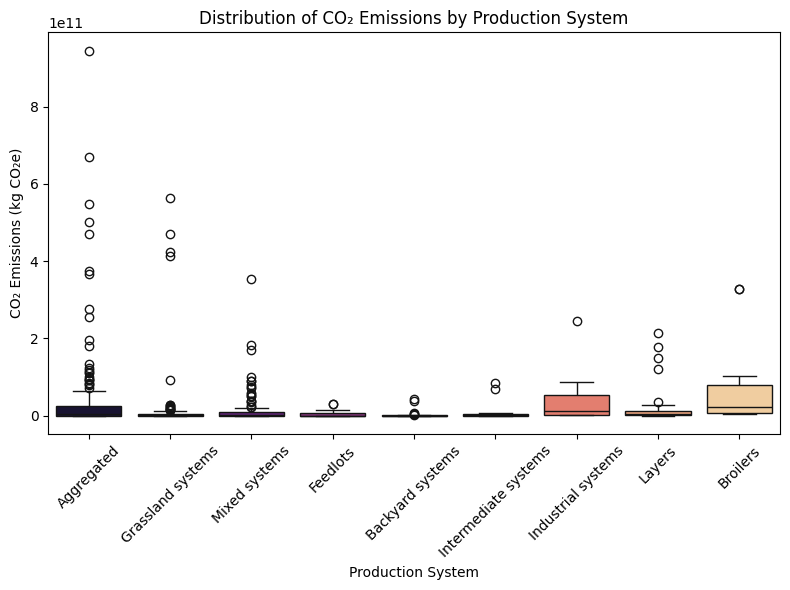

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=livestock_subset,
    x='production_system', y='co2_emissions_kg',
    palette='magma'
)
plt.title('Distribution of CO₂ Emissions by Production System')
plt.ylabel('CO₂ Emissions (kg CO₂e)')
plt.xlabel('Production System')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

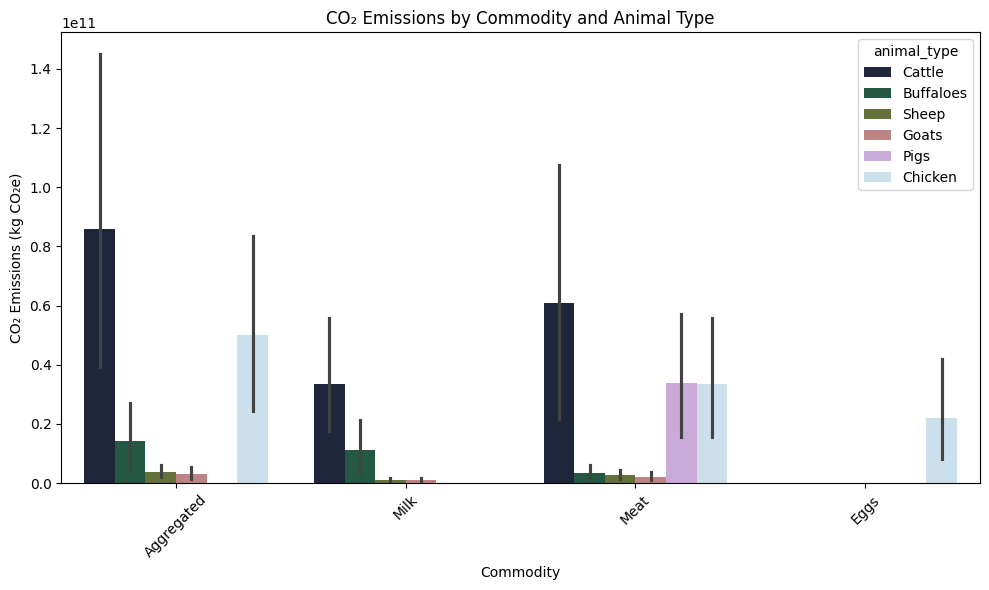

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=livestock_subset,
    x='commodity', y='co2_emissions_kg',
    hue='animal_type', palette='cubehelix'
)
plt.title('CO₂ Emissions by Commodity and Animal Type')
plt.ylabel('CO₂ Emissions (kg CO₂e)')
plt.xlabel('Commodity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

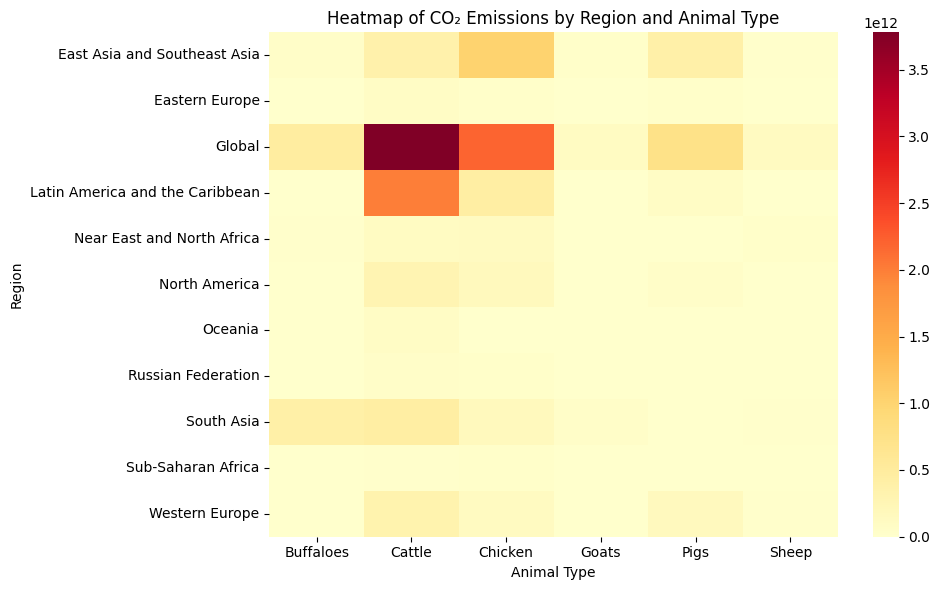

In [15]:
pivot = livestock_subset.pivot_table(
    values='co2_emissions_kg',
    index='region', columns='animal_type',
    aggfunc='sum'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='YlOrRd', annot=False, fmt=".1f")
plt.title('Heatmap of CO₂ Emissions by Region and Animal Type')
plt.xlabel('Animal Type')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

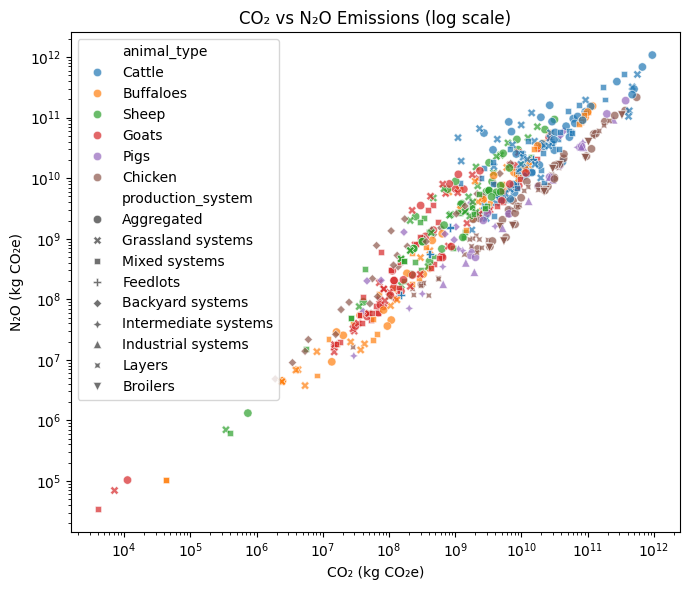

In [16]:
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=livestock_subset,
    x='co2_emissions_kg',
    y='n2o_emissions_kg',
    hue='animal_type', style='production_system', alpha=0.7
)
plt.xscale('log')
plt.yscale('log')
plt.title('CO₂ vs N₂O Emissions (log scale)')
plt.xlabel('CO₂ (kg CO₂e)')
plt.ylabel('N₂O (kg CO₂e)')
plt.tight_layout()
plt.show()